In [107]:
import sys
sys.path.append('..')
from db1 import *
import pandas as pd

R = PolynomialRing(ZZ, 't')
t = R.gen()

def is_paving(M):
    n = M.size()
    r = M.rank()
    return (len(M.independent_r_sets(r-1)) == binomial(n, r-1))

def q_kl(k, h):
    return kazhdan_lusztig_inverse_uniform(k, h+1) - kazhdan_lusztig_inverse_uniform(k-1, h)

def kl_inverse_fast(M):
    if M.loops(): return R(0)
    k, n = M.rank(), M.size()
    if k == n or k == 0: return R(1)
    if not M.is_connected():
        ans = R(1)
        CC = M.components()
        for N in CC:
            res = M.delete(M.groundset() - N)
            ans = ans * kl_inverse_fast(res)
        return ans

    if is_paving(M):
        return kl_inverse_paving(M)
    if is_paving(M.dual()):
        return kl_inverse_copaving(M)
    """
    if n <= 8 and M.is_connected():
        for i in range(len(mat[n][k])):
            if mat[n][k][i].is_isomorphic(M):
                return ikl[n][k][i]
    """
    LF = M.lattice_of_flats()
    ans = R(0)
    for F in LF:
        if len(F) != n:
            Res = M.delete(M.groundset() - F)
            Con = M.contract(F)
            chi = characteristic_polynomial(Con)(1/t) * t**(Con.rank())
            PPP = kl_inverse_fast(Res)(t) * (-1)**(Res.rank())
            ans = ans + chi * PPP
    assert (t**k * ans(1/t)).numerator() == -ans(t)
    ans = ans.numerator() * (-1)**(k+1)
    return ans.truncate((k+1)//2)

def kazhdan_lusztig_inverse_uniform(k, n):
    if k == n:
        return R(1)
    d = k
    m = n - d
    ans = 0
    for j in range((d-1)//2 + 1):
        ans = ans + m * (d-2*j)/((m+j) * (m+d-j)) * binomial(d, j) * t**j
    return ans * binomial(m+d, d)

def kl_inverse_paving(M):
    assert is_paving(M)
    n = M.size()
    k = M.rank()
    ans = kazhdan_lusztig_inverse_uniform(k, n)
    for H in M.hyperplanes():
        h = len(H)
        if h >= k:
            ans = ans - q_kl(k, h)
    return ans

def kl_inverse_copaving(M):
    assert is_paving(M.dual())
    n = M.size()
    k = M.rank()
    ans = kazhdan_lusztig_inverse_uniform(k, n)
    for H in M.dual().hyperplanes():
        h = len(H)
        if h >= n-k:
            ans = ans - kli_vtilde_dual(n-k, h, n) + kazhdan_lusztig_inverse_uniform(h-n+k+1, h) * kazhdan_lusztig_inverse_uniform(n-h-1, n-h)
    return ans

def kli_vtilde_dual(k, h, n):
    return helper1(n-k, h, n)

def helper1(k, h, n):
    c = n - h
    ans1 = kazhdan_lusztig_inverse_uniform(k, n)
    ans2 = helper2(c, k, n)
    ans3 = kazhdan_lusztig_inverse_uniform(k-c+1, h) * kazhdan_lusztig_inverse_uniform(c-1, c)
    return ans1 - ans2 + ans3

def helper2(c, k, n):
    h = n - c
    ans = 0
    for j in range(k-c+1):
        ans = ans + binomial(n-c, j) * (-1)**(c-1+j) * kazhdan_lusztig_inverse_uniform(c-1, c) * t**(k-c-j+1) * chuly(k-c-j+1, n-c-j)(1/t)
    for i in range(c-1):
        for j in range(k-i):
            ans = ans + binomial(c, i) * binomial(n-c, j) * (-1)**(i+j) * t**(k-i-j) * helper4(c, k, n, i, j)(1/t)
    ans = ans.numerator().truncate((k-1)//2 + 1)
    if ans[0] < 0:
        ans = -ans
    return ans

def helper3(c, k, n):
    ans = 0
    for j in range(k-c+1):
        ans = ans + binomial(n-c, j) * kazhdan_lusztig_uniform_matroid(c-1, c) * (-1)**(k-c-j+1) * kazhdan_lusztig_inverse_uniform(k-c-j+1, n-c-j)
    for i in range(c-1):
        for j in range(k-i):
            ans = ans + binomial(c, i) * binomial(n-c, j) * (-1)**(k-i-j) * helper2(c-i, k-i-j, n-i-j)
    return -ans

def helper4(c, k, n, i, j):
    ans = 0
    for l in range(c-i-1):
        ans = ans + (-1)**l * (t-1)**(max(n-i-j-l-1, 0))
    for u in range(n-k-1):
        ans = doit_once(ans)
    return ans

def chuly(a, b):
    ans = (t-1)**b
    for i in range(b-a):
        ans = doit_once(ans)
    return ans

def doit_once(p):
    p = p // t**2
    p = p * t
    p = p - p(1)
    return p

def lorenzo(k, h, n):
    c = n - h
    ans1 = kazhdan_lusztig_uniform_matroid(k, n) + kazhdan_lusztig_uniform_matroid(k-c+1, h) * kazhdan_lusztig_uniform_matroid(c-1, c)
    ans2 = helper3(c, k, n)
    return ans1 - ans2

In [108]:
#creating parallel connection of cycles
m, n = 4, 5

def parallel_connection(m, n):
    G = graphs.CycleGraph(m + n - 2)
    G.add_edge(0, m-1)
    edge_e = frozenset({(0, m - 1)})
    return G, edge_e

In [109]:
def leading_term(p):
    return p.leading_coefficient() * t ** p.degree()

def lt(M):
    r = M.rank()
    if r % 2 == 1:
        return leading_term(kl_inverse_fast(M))
    else:
        return 0

def extra(m, n):
    return S( t * uniformQpoly(m-2, m-1) * lt(matroids.Uniform(n-2, n-1))
            + t * uniformQpoly(n-2, n-1) * lt(matroids.Uniform(m-2, m-1)))

In [110]:
S = PolynomialRing(ZZ, 't')

from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["n", "QMn", "QMdel", "Qdiff", "Qcon", "diffQcon", "extra term"]

m = 5
for n in range(3, 20):
    G, e = parallel_connection(m, n)
    QMn = S(kl_inverse_fast(Matroid(G)))
    QMdel = S(uniformQpoly(n+m-3, n+m-2))
    Qdiff = S(QMn - QMdel)
    Qcon = S(uniformQpoly(n-2, n-1) * uniformQpoly(m-2, m-1))
    diffQcon = Qdiff - S(t + 1) * Qcon
    extra_term = extra(m, n) + diffQcon
    table.add_row([n, QMn.factor(), QMdel.factor(), Qdiff, Qcon.factor(), diffQcon, extra_term])

table.max_width = 25  # Set the maximum width for each column

print(table)

for n in range(3, 13):
    G, e = parallel_connection(m, n)
    QMn = S(kl_inverse_fast(Matroid(G)))
    QMdel = S(uniformQpoly(n+m-3, n+m-2))
    Qdiff = S(QMn - QMdel)
    Qcon = S(uniformQpoly(n-2, n-1) * uniformQpoly(m-2, m-1))
    diffQcon = Qdiff - S(t+1) * Qcon
    extra_term = extra(m, n)

    print(f"n = {n}, Qdiff = {Qdiff.factor()}")
    print(f"QMn = {QMn.factor()}, QMdel = {QMdel.factor()}, Qcon = {Qcon.factor()}")
    print(f"diffQcon = {diffQcon}\n")
    print(f"extra term = {extra_term}\n")

+----+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+------------+
| n  |            QMn            |           QMdel           |           Qdiff           |            Qcon           |          diffQcon         | extra term |
+----+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+------------+
| 3  |    (t + 1) * (3*t + 8)    |      5*t^2 + 9*t + 5      |      -2*t^2 + 2*t + 3     |          2*t + 3          |        -4*t^2 - 3*t       |     0      |
| 4  |   2 * (7*t^2 + 12*t + 6)  |   2 * (7*t^2 + 7*t + 3)   |          10*t + 6         |       2 * (2*t + 3)       |           -4*t^2          |     0      |
| 5  |  10*t^3 + 32*t^2 + 41*t + |  14*t^3 + 28*t^2 + 20*t + | -4*t^3 + 4*t^2 + 21*t + 9 |        (2*t + 3)^2        |      -8*t^3 - 12*t^2      |     0      |
|    |             16            |      

In [111]:
matroids_list = [matroids.Uniform(r, n) for r, n in [(4, 7), (2, 4), (2,5), (3, 4), (4, 5), (5,6), (3, 5), (4, 6)]] + \
    [matroids.Wheel(i) for i in range(3, 6)] + \
    [matroids.Whirl(i) for i in range(3, 5)] + \
    [matroids.PG(n, 2) for n in range(3, 4)] + \
    [matroids.PG(n, 3) for n in range(3, 4)]

es = [next(({e} for e in m.groundset() if e not in m.coloops()), None) for m in matroids_list]

In [112]:
def set_division(L, e):
    divs = {'A': set(), 'B': set(), 'C': set(), 'D': set()}
    for x in L:
        if set(e).issubset(set(x)):
            if frozenset(set(x) - set(e)) in L:
                divs['A'].add(x)
            else:
                divs['D'].add(x)
        else:
            if frozenset(set(x) | set(e)) in L:
                divs['C'].add(x)
            else:
                divs['B'].add(x)
    return divs

def qtau(M):
    return (kl_inverse_fast(M).leading_coefficient() if M.rank() % 2 == 1 else 0) 
    
def extra_terms(M, e):
    L = M.lattice_of_flats()
    set_divs = set_division(L, e)
    extra = 0
    for x in set_divs['C']:
        if M.contract(x.union(e)).rank() % 2 == 1:
            extra += qtau(M.contract(x.union(e))) * t**((M.rank()-M.rank(x))/2) * \
                    kl_inverse_fast(M.delete(x))
                
    return extra

In [113]:
table2 = PrettyTable()
table2.field_names = ["M.rank()", "QMn", "QMdel", "Qdiff", "Qcon", "diffQcon", "extra term"]

for m, e in zip(matroids_list, es):
    QMn = S(kl_inverse_fast(m))
    QMdel = S(kl_inverse_fast(m.delete(e)))
    Qdiff = S(QMn - QMdel)
    Qcon = S(kl_inverse_fast(m.contract(e)))
    diffQcon = Qdiff - S(t+1) * Qcon
    extra_term = extra_terms(m, e)
    table2.add_row([m.rank(), QMn.factor(), QMdel.factor(), Qdiff, Qcon.factor(), diffQcon, extra_term])

table.max_width = 30  # Set the maximum width for each column

print(table2)

+----------+---------------------+----------------------+-----------------+---------------+--------------+----------------------------------+
| M.rank() |         QMn         |        QMdel         |      Qdiff      |      Qcon     |   diffQcon   |            extra term            |
+----------+---------------------+----------------------+-----------------+---------------+--------------+----------------------------------+
|    4     |    5 * (7*t + 4)    |    2 * (8*t + 5)     |    19*t + 10    |    9*t + 10   |    -9*t^2    |     315*t^3 + 255*t^2 + 60*t     |
|    2     |          3          |          2           |        1        |       1       |      -t      |               3*t                |
|    2     |         2^2         |          3           |        1        |       1       |      -t      |               4*t                |
|    3     |       2*t + 3       |          1           |     2*t + 2     |       2       |      0       |               3*t                |
|    4

In [114]:
table3 = PrettyTable()
table3.field_names = ["n", "QMn", "QMdel", "Qdiff", "Qcon", "diffQcon", "extra term"]

for n in range(3, 13):
    M = matroids.Uniform(n-1, n)
    e = next(({e} for e in M.groundset() if e not in M.coloops()), None)
    QMn = S(uniformQpoly(n-1, n))
    QMdel = S(1)
    Qdiff = S(QMn - QMdel)
    Qcon = S(uniformQpoly(n-2, n-1))
    diffQcon = Qdiff - S(t + 1) * Qcon
    extra_term = extra_terms(M, e)
    table3.add_row([n, QMn.factor(), QMdel.factor(), Qdiff, Qcon.factor(), diffQcon, extra_term])

table3.max_width = 25  # Set the maximum width for each column

print(table3)

+----+---------------------------+-------+---------------------------+---------------------------+----------+---------------------------+
| n  |            QMn            | QMdel |           Qdiff           |            Qcon           | diffQcon |         extra term        |
+----+---------------------------+-------+---------------------------+---------------------------+----------+---------------------------+
| 3  |             2             |   1   |             1             |             1             |    -t    |            2*t            |
| 4  |          2*t + 3          |   1   |          2*t + 2          |             2             |    0     |            3*t            |
| 5  |          5*t + 4          |   1   |          5*t + 3          |          2*t + 3          |  -2*t^2  |    10*t^3 + 8*t^2 + 6*t   |
| 6  |      5*t^2 + 9*t + 5      |   1   |      5*t^2 + 9*t + 4      |          5*t + 4          |    0     |       10*t^2 + 10*t       |
| 7  |   2 * (7*t^2 + 7*t + 3)   |

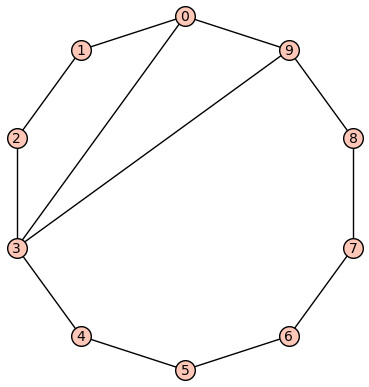

In [185]:
n = 10
k = 3
G2 = graphs.CycleGraph(n)
G2.add_edge(0,k)
G2.add_edge(k,n-1)
e = frozenset({(k, n-1)})
G2.show()

In [186]:
M = Matroid(G2)
print(kl_inverse_fast(Matroid(G2)))

32*t^4 + 118*t^3 + 173*t^2 + 117*t + 36


In [187]:
def circuits_containing_element(M, e):
    circuits_with_e = [circuit for circuit in M.circuits() if e.issubset(set(circuit))]
    return circuits_with_e

circuits_containing_element(M, e)

[frozenset({(0, 1), (0, 9), (1, 2), (2, 3), (3, 9)}),
 frozenset({(3, 4), (3, 9), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)}),
 frozenset({(0, 3), (0, 9), (3, 9)})]

In [188]:
def sumatC(M, C):
    sum = 0
    for c in C:
        sum += S( t * kl_inverse_fast(M.contract(c)) *\
        lt(M.delete(M.groundset() - c).contract(e)))
    return sum

sumatC(M, circuits_containing_element(M, e))

10*t^4 + 25*t^3 + 18*t^2 + 10*t

In [189]:
kl_inverse_fast(M) - kl_inverse_fast(M.delete(e)) - (t+1) * kl_inverse_fast(M.contract(e))

-20*t^4 - 43*t^3 - 28*t^2 - 10*t